# Wine Case Analysis: *Wine Spectator*'s Top 100 Wines, 1988-2020
List available online on *Wine Spectator*'s [Top 100 Lists web site](https://top100.winespectator.com/lists/).

## File Setup

In [344]:
# import and initialize main python libraries
import numpy as np
import pandas as pd
import shapefile as shp
import matplotlib.pyplot as plt
import bar_chart_race as bcr
import seaborn as sns

# import libraries for file navigation
import os
import shutil
import glob
from pandas_ods_reader import read_ods

# import other packages
from scipy import stats
from sklearn import linear_model

# import geo packages
import geopandas as gpd
import descartes
from shapely.geometry import Point, Polygon

# import Geopy packages
import geopy
from geopy.geocoders import Nominatim

In [345]:
# initialize vizualization set
sns.set(style="whitegrid", palette="colorblind", color_codes=True)
sns.mpl.rc("figure", figsize=(10, 6))

# Jupyter Notebook
%matplotlib inline

## Dataframe Exploration

In [346]:
# Note: save CSV files in UTF-8 format to preserve special characters.
df_Wine = pd.read_csv('./Wine_Hier00.csv')
df_GeoCache = pd.read_csv('./GeoCache.csv')
df_Flag = pd.read_csv('./emoji_list.csv')

In [347]:
df_Wine.shape

(3304, 25)

In [348]:
df_Wine.dtypes

Review_Year           float64
Rank                   object
Vintage                object
Score                 float64
Price                  object
Winemaker              object
Wine                   object
Wine_Style             object
Grape_Blend            object
Blend_List             object
Geography              object
Cases_Made            float64
Cases_Imported        float64
Reviewer               object
Drink_now             float64
Best_Drink_from       float64
Best_Drink_Through    float64
Review                 object
Hierarchy              object
Address                object
loc                    object
point                  object
lat                   float64
long                  float64
altitude              float64
dtype: object

In [349]:
# CSV of wines is retaining a blank row at the end of the dataset. Remove the last row to prevent data type errors.

# number of rows to drop
n = 1

df_Wine.drop(df_Wine.tail(n).index, inplace = True)

In [350]:
# Review_Year
# Convert Review_Year from float to int
df_Wine['Review_Year'] = df_Wine['Review_Year'].astype(int)

In [351]:
df_GeoCache.shape

(1228, 8)

In [352]:
df_Flag.shape

(19, 3)

In [353]:
df_Wine.sample(10)

,Review_Year,Rank,Vintage,Score,Price,Winemaker,Wine,Wine_Style,Grape_Blend,Blend_List,...,Best_Drink_from,Best_Drink_Through,Review,Hierarchy,Address,loc,point,lat,long,altitude
499,2016,99,2013,94.0,125,Cirq,Pinot Noir Russian River Valley Treehouse,Red,Pinot Noir,NaN,...,2016.0,2022.0,"Combining power and finesse, this is rich and ...",Hierarchy_00,USA,United States,"(39.7837304, -100.4458825, 0.0)",39.783730,-100.445882,0.0
1400,2007,99,2005,91.0,30,Erath,Pinot Noir Dundee Hills Estate Selection,Red,Pinot Noir,NaN,...,2008.0,2015.0,"Smooth, round and generous with its red berry-...",Hierarchy_00,USA,United States,"(39.7837304, -100.4458825, 0.0)",39.783730,-100.445882,0.0
110,2019,11,2015,97.0,62,Moccagatta,Barbaresco Bric Balin,Red,Blend,Nebbiolo,...,2023.0,2043.0,"Offers an intense display of cherry, kirsch, r...",Hierarchy_00,Italy,Italia,"(42.6384261, 12.674297, 0.0)",42.638426,12.674297,0.0
2457,1996,56,1993,92.0,30,Marquis d'Angerville,Volnay Premier Cru,Red,Pinot Noir,NaN,...,1999.0,NaN,"Great fruit combines with intriguing, spicy ac...",Hierarchy_00,France,France,"(46.603354, 1.8883335, 0.0)",46.603354,1.888333,0.0
2859,1992,57,1990,92.0,30,Robert Mondavi,Pinot Noir Napa Valley Reserve,Red,Pinot Noir,NaN,...,1992.0,NaN,"Powerful and complete, with depth, complexity ...",Hierarchy_00,USA,United States,"(39.7837304, -100.4458825, 0.0)",39.783730,-100.445882,0.0
1733,2003,32,2000,95.0,65,Albino Rocca,Barbaresco Vigneto Brich Ronchi,Red,Blend,Nebbiolo,...,2008.0,NaN,"Very attractive aromas of ripe plum, berry and...",Hierarchy_00,Italy,Italia,"(42.6384261, 12.674297, 0.0)",42.638426,12.674297,0.0
1309,2007,8,2006,95.0,80,Mollydooker,Shiraz McLaren Vale Carnival of Love,Red,Shiraz | Syrah,NaN,...,2007.0,2020.0,A stunning wine of immense depth and integrity...,Hierarchy_00,Australia,Australia,"(-24.7761086, 134.755, 0.0)",-24.776109,134.755000,0.0
2238,1998,14,1996,92.0,14,Meridian,Chardonnay Edna Valley Coastal Reserve,White,Chardonnay,NaN,...,NaN,NaN,"Beautifully crafted, this California white is ...",Hierarchy_00,USA,United States,"(39.7837304, -100.4458825, 0.0)",39.783730,-100.445882,0.0
1318,2007,17,2005,93.0,35,Orin Swift,The Prisoner Napa Valley,Red,Blend,"Zinfandel, Cabernet Sauvignon, Syrah, Petite S...",...,2007.0,2011.0,A delicious wine that offers the best of both ...,Hierarchy_00,USA,United States,"(39.7837304, -100.4458825, 0.0)",39.783730,-100.445882,0.0
975,2011,74,2006,96.0,125,Marcassin,Chardonnay Sonoma Coast Marcassin Vineyard,White,Chardonnay,NaN,...,2011.0,2017.0,"At once bold, rich and layered, with a measure...",Hierarchy_00,USA,United States,"(39.7837304, -100.4458825, 0.0)",39.783730,-100.445882,0.0


## Vintage Wines where Cases Made was Non-Zero

In [354]:
# replace 'NaN' results in chart with 0 to facilitate analysis
df_Wine.fillna(value = 0, inplace = True)

In [355]:
# drop the non-numeric price row from the dataset
df_Wine = df_Wine[df_Wine.Price != '$49 / 500ml']

In [356]:
# Convert data type of price to numeric
df_Wine['Price'] = pd.to_numeric(df_Wine.Price, downcast = 'float')

In [357]:
df_Wine.dtypes

Review_Year             int64
Rank                   object
Vintage                object
Score                 float64
Price                 float32
Winemaker              object
Wine                   object
Wine_Style             object
Grape_Blend            object
Blend_List             object
Geography              object
Cases_Made            float64
Cases_Imported        float64
Reviewer               object
Drink_now             float64
Best_Drink_from       float64
Best_Drink_Through    float64
Review                 object
Hierarchy              object
Address                object
loc                    object
point                  object
lat                   float64
long                  float64
altitude              float64
dtype: object

In [358]:
# Remove Non-Vintage (NV) wines from df_Wine
# Include only wines with a Cases_Made value

df_Wine_V = df_Wine[
    (df_Wine.Vintage != 'NV')
]

df_Wine_V.shape

(3247, 25)

In [359]:
# Average Score by Wine Style - All Years
df_SWS_All = pd.DataFrame({'Avg_Score' : df_Wine_V.groupby(['Wine_Style'])['Score'].mean()}).reset_index()
df_SWS_All

,Wine_Style,Avg_Score
0,Dessert & Fortified,95.318841
1,Red,93.125164
2,Rosé | Rosado,90.444444
3,Sparkling,93.586957
4,White,91.978313


In [360]:
# Average Score by Wine Style - By Review Year
df_SWS_ByYear = pd.DataFrame({'Avg_Score' : df_Wine_V.groupby(['Review_Year', 'Wine_Style'])['Score'].mean()}).reset_index()
df_SWS_ByYear.sample(10)

,Review_Year,Wine_Style,Avg_Score
38,1998,Sparkling,96.000000
51,2002,Red,92.520548
57,2004,Red,93.000000
121,2019,Sparkling,93.000000
5,1989,Sparkling,92.500000
18,1993,Red,93.338235
52,2002,White,91.360000
19,1993,Sparkling,92.666667
17,1992,White,91.777778
115,2018,Rosé | Rosado,90.000000


In [361]:
# Average Score by Wine Style - All Years
df_PWS_All = pd.DataFrame({'Avg_Price' : df_Wine_V.groupby(['Wine_Style'])['Price'].mean()}).reset_index()
df_PWS_All

,Wine_Style,Avg_Price
0,Dessert & Fortified,65.579712
1,Red,46.081116
2,Rosé | Rosado,24.777779
3,Sparkling,70.586960
4,White,29.065060


In [362]:
# Average Score by Wine Style - By Vintage Year
df_PWS_ByYear = pd.DataFrame({'Avg_Price' : df_Wine_V.groupby(['Review_Year', 'Wine_Style'])['Price'].mean()}).reset_index()
df_PWS_ByYear.sample(10)

,Review_Year,Wine_Style,Avg_Price
105,2016,Red,49.970589
58,2004,Sparkling,55.000000
123,2020,Dessert & Fortified,26.000000
89,2012,Sparkling,54.000000
79,2010,Dessert & Fortified,48.666668
84,2011,Sparkling,45.000000
107,2016,Sparkling,42.000000
103,2015,White,38.043480
50,2001,White,25.653847
43,2000,Dessert & Fortified,54.000000


In [363]:
# Average Score by Address - All Years
df_SA_All = pd.DataFrame({'Avg_Score' : df_Wine_V.groupby(['Address'])['Score'].mean()}).reset_index()
df_SA_All

,Address,Avg_Score
0,Argentina,91.982456
1,Australia,92.390625
2,Austria,91.571429
3,Canada,94.000000
4,Chile,92.122807
5,France,93.618490
6,Germany,92.213115
7,Greece,90.250000
8,Hungary,94.250000
9,Israel,91.000000


In [364]:
# Average Score by Address - By Review Year
df_SA_ByYear = pd.DataFrame({'Avg_Score' : df_Wine_V.groupby(['Review_Year', 'Address'])['Score'].mean()}).reset_index()
df_SA_ByYear.sample(10)

,Review_Year,Address,Avg_Score
6,1988,USA,92.264706
99,2000,South Africa,92.000000
306,2017,Argentina,91.000000
164,2006,Germany,93.500000
310,2017,France,93.900000
242,2012,France,93.380952
75,1998,Australia,91.500000
256,2013,Germany,91.500000
340,2019,Italy,92.600000
135,2003,USA,92.000000


In [365]:
# Average Score by Wine Style - All Years
df_PA_All = pd.DataFrame({'Avg_Price' : df_Wine_V.groupby(['Address'])['Price'].mean()}).reset_index()
df_PA_All

,Address,Avg_Price
0,Argentina,37.473682
1,Australia,35.182293
2,Austria,25.821428
3,Canada,55.000000
4,Chile,39.385963
5,France,56.552082
6,Germany,25.852459
7,Greece,18.083334
8,Hungary,80.625000
9,Israel,37.142857


In [366]:
# Average Score by Wine Style - By Review Year
df_PA_ByYear = pd.DataFrame({'Avg_Price' : df_Wine_V.groupby(['Review_Year', 'Address'])['Price'].mean()}).reset_index()
df_PA_ByYear.sample(10)

,Review_Year,Address,Avg_Price
51,1995,New Zealand,27.000000
26,1991,USA,21.459459
230,2011,Germany,30.000000
133,2003,South Africa,22.333334
307,2017,Australia,20.600000
170,2006,Spain,28.000000
71,1997,Portugal,46.250000
310,2017,France,51.450001
216,2010,France,73.388885
213,2010,Australia,35.666668


### Visualization

In [367]:
# set palette and dimensions
palette = sns.color_palette('colorblind')

In [368]:
# define a function to graph summary data

def summary_barplot(price_or_score, style_or_address):
    
    if price_or_score == 'Price':
        if style_or_address == 'Wine_Style':
            df = df_PWS_All
        elif style_or_address == 'Address':
            df = df_PA_All
        else:
            print('select style or address')
    elif price_or_score == 'Score':
        if style_or_address == 'Wine_Style':
            df = df_SWS_All
        elif style_or_address == 'Address':
            df = df_SA_All
    else:
        print('price or score')
        
    g = sns.catplot(
        data = df,
        kind = 'bar',
        y = style_or_address,
        x = 'Avg_' + price_or_score
    )
    
    g.despine(left = True)
    g.set_axis_labels('Average ' + price_or_score, 'Wine Style')
    
    plt.suptitle('Average ' + price_or_score + ' by ' + style_or_address + ', 1988-2020', y = 1.1)
    plt.savefig('./images/catplot_avg_' + price_or_score + '_by_' + style_or_address + '.png')

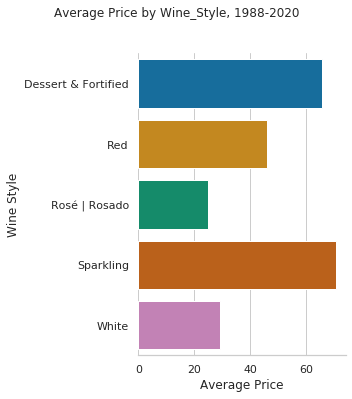

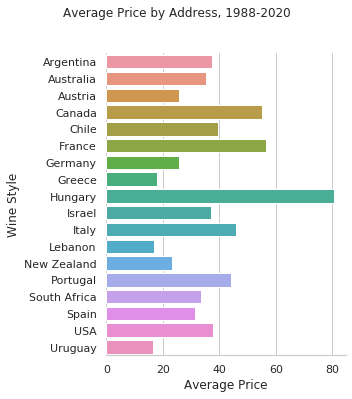

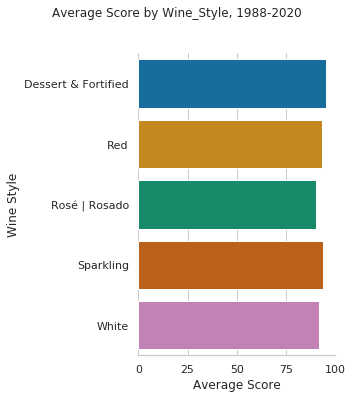

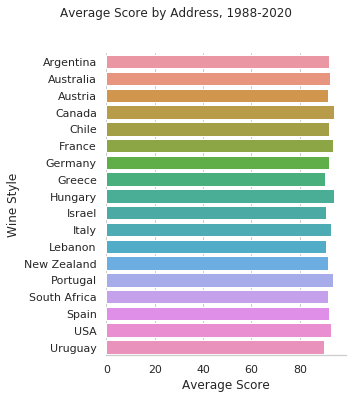

In [369]:
x_list = ['Price', 'Score']
y_list = ['Wine_Style', 'Address']

for x in x_list:
    for y in y_list:
        summary_barplot(x, y)

In [370]:
# define a function to graph summary data

def summary_boxplot(price_or_score, style_or_address):
    
    df = df_Wine_V
    
    sns.mpl.rc("figure", figsize=(15, 10))
    
    g = sns.boxplot(
        data = df,
        y = style_or_address,
        x = price_or_score,
        showmeans = True
    )
    
    plt.suptitle(price_or_score + ' by ' + style_or_address + ',/nReview Years 1988-2020')
    plt.savefig('./images/boxplot_' + price_or_score + '_by_' + style_or_address + '.png')

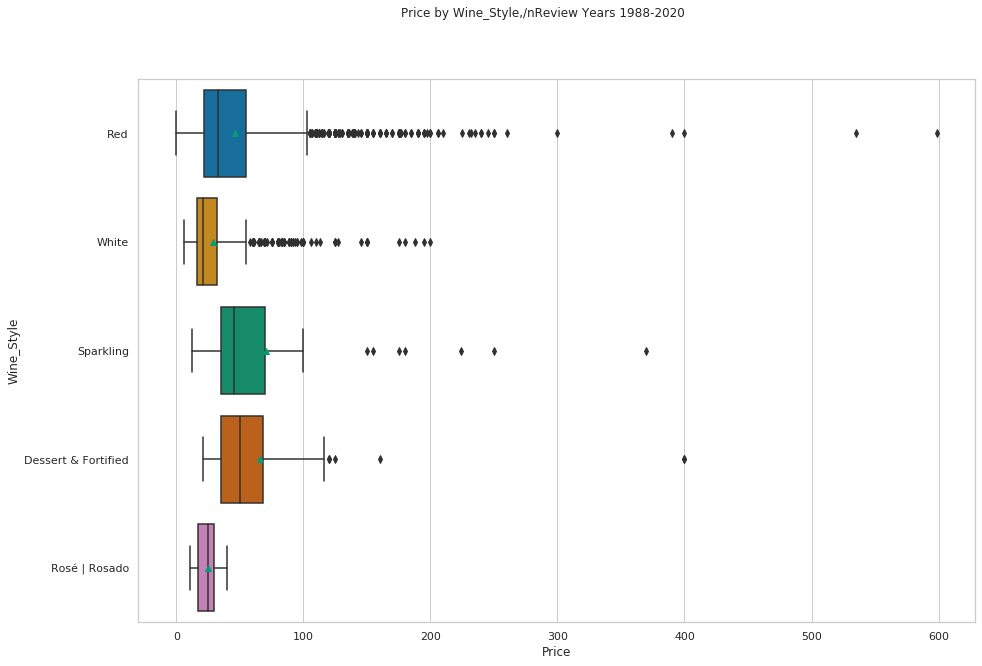

In [371]:
summary_boxplot('Price', 'Wine_Style')

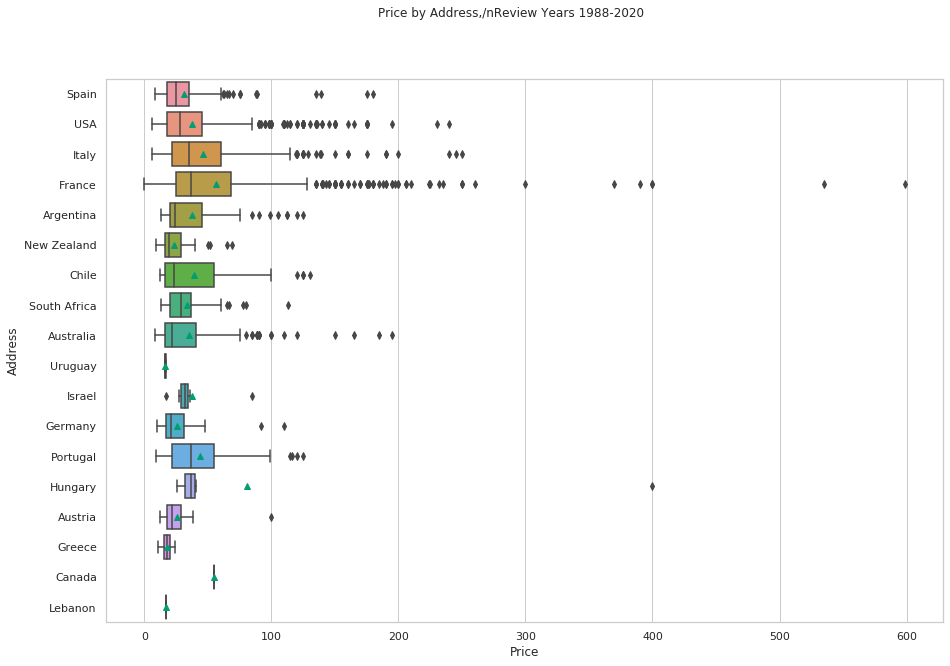

In [372]:
summary_boxplot('Price', 'Address')

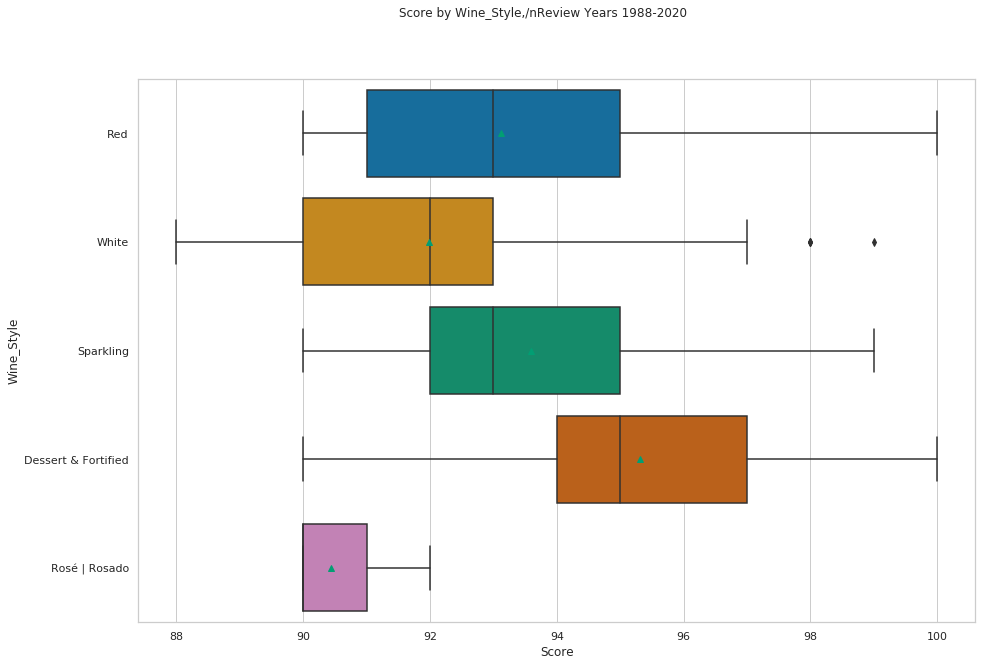

In [373]:
summary_boxplot('Score', 'Wine_Style')

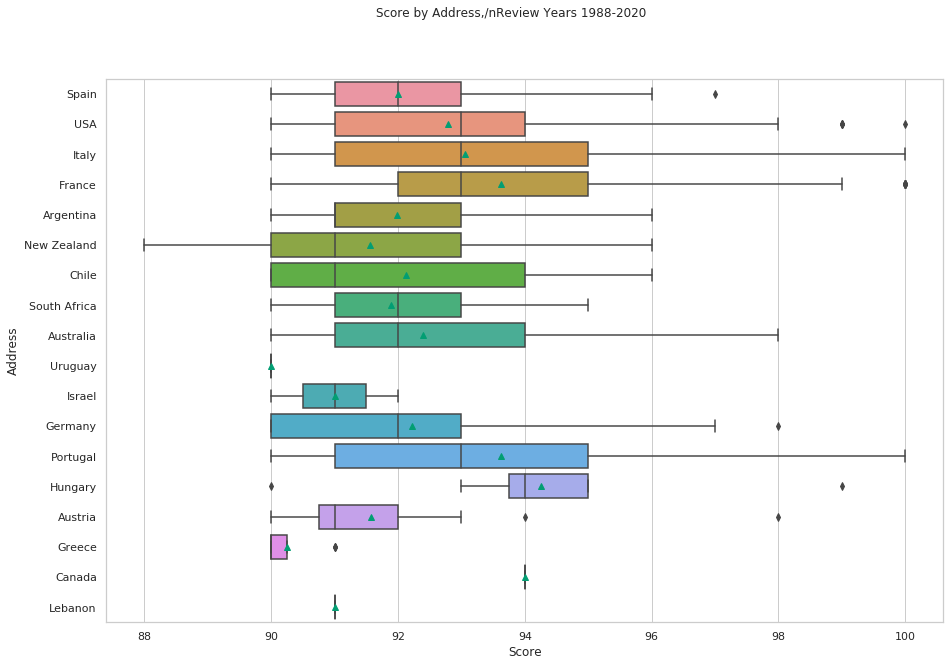

In [374]:
summary_boxplot('Score', 'Address')

In [375]:
# define a function to graph summary data by Review Year

def summary_by_year_lineplot(price_or_score, style_or_address):
    if price_or_score == 'Price':
        if style_or_address == 'Wine_Style':
            df = df_PWS_ByYear
        elif style_or_address == 'Address':
            df = df_PA_ByYear
        else:
            print('select style or address')
    elif price_or_score == 'Score':
        if style_or_address == 'Wine_Style':
            df = df_SWS_ByYear
        elif style_or_address == 'Address':
            df = df_SA_ByYear
    else:
        print('price or score')
        
    g = sns.relplot(
        data = df,
        y = 'Avg_' + price_or_score,
        x = 'Review_Year',
        col = style_or_address,
        col_wrap = 3,
        kind = 'line'
    )
    
    g.despine(left = True)
    g.set_axis_labels('Average ' + price_or_score, style_or_address)
    
    if style_or_address == 'Wine_Style':
        y = 1.05
    else: 
        y = 1.01
    
    plt.suptitle('Average ' + price_or_score + ' by ' + style_or_address + ' by Review Year', y = y)
    plt.savefig('./images/relplot_avg_' + price_or_score + '_by_' + style_or_address + '.png')

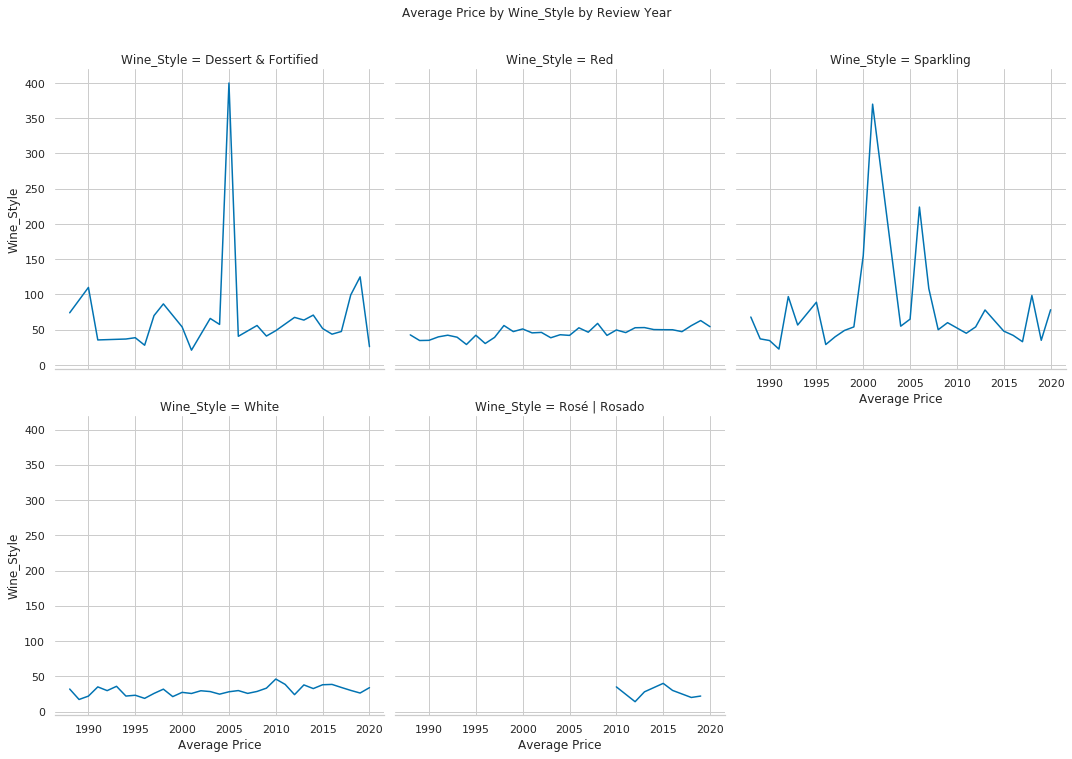

In [376]:
summary_by_year_lineplot('Price', 'Wine_Style')

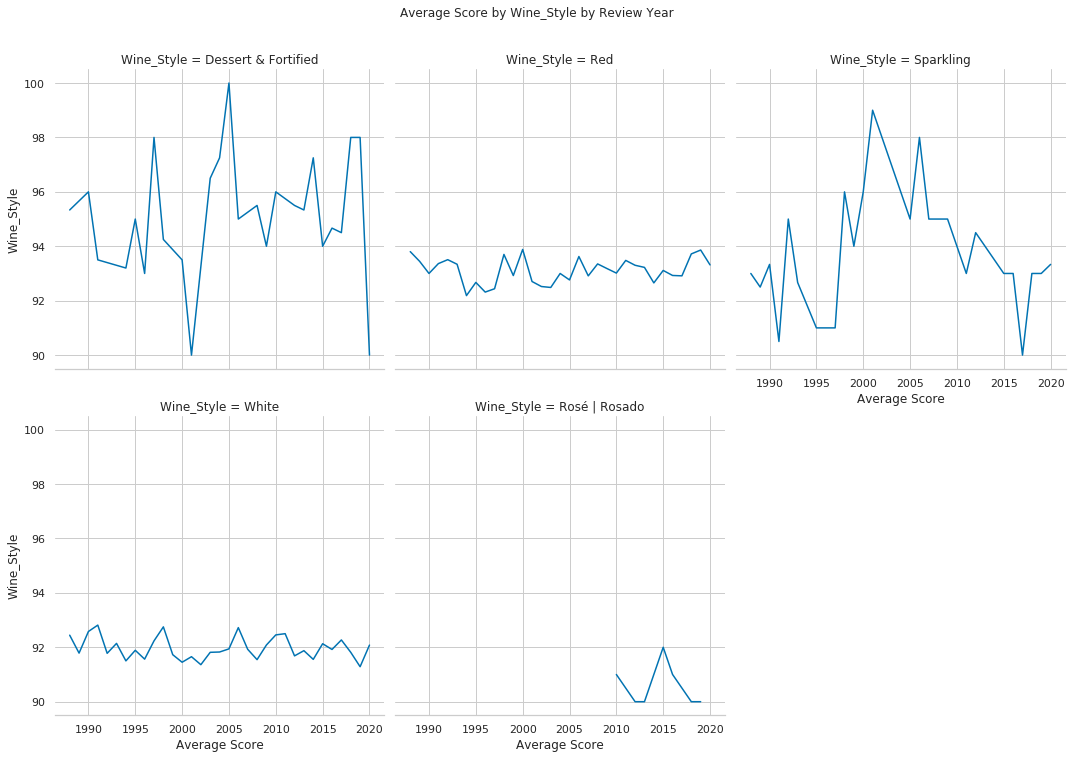

In [377]:
summary_by_year_lineplot('Score', 'Wine_Style')

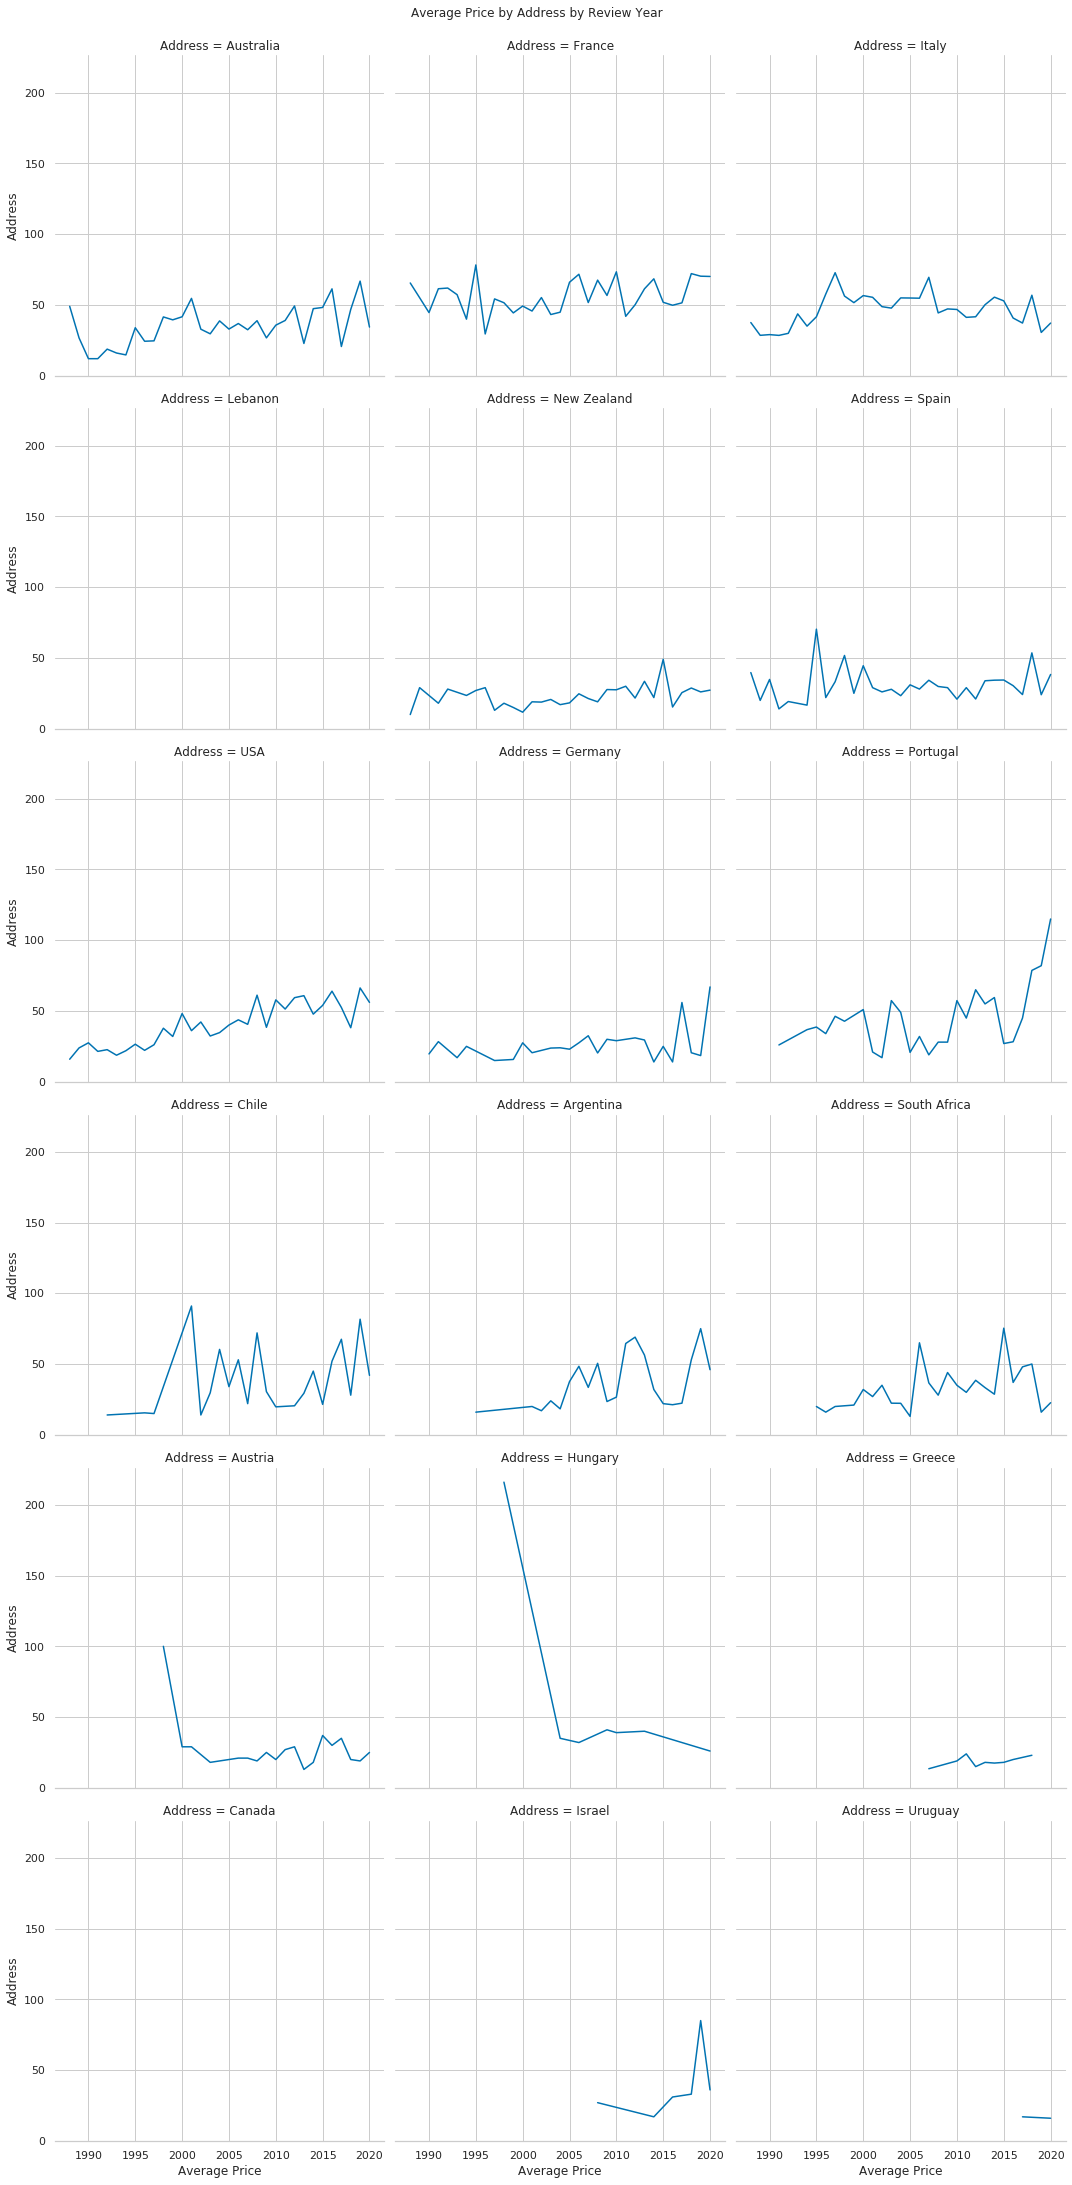

In [378]:
summary_by_year_lineplot('Price', 'Address')

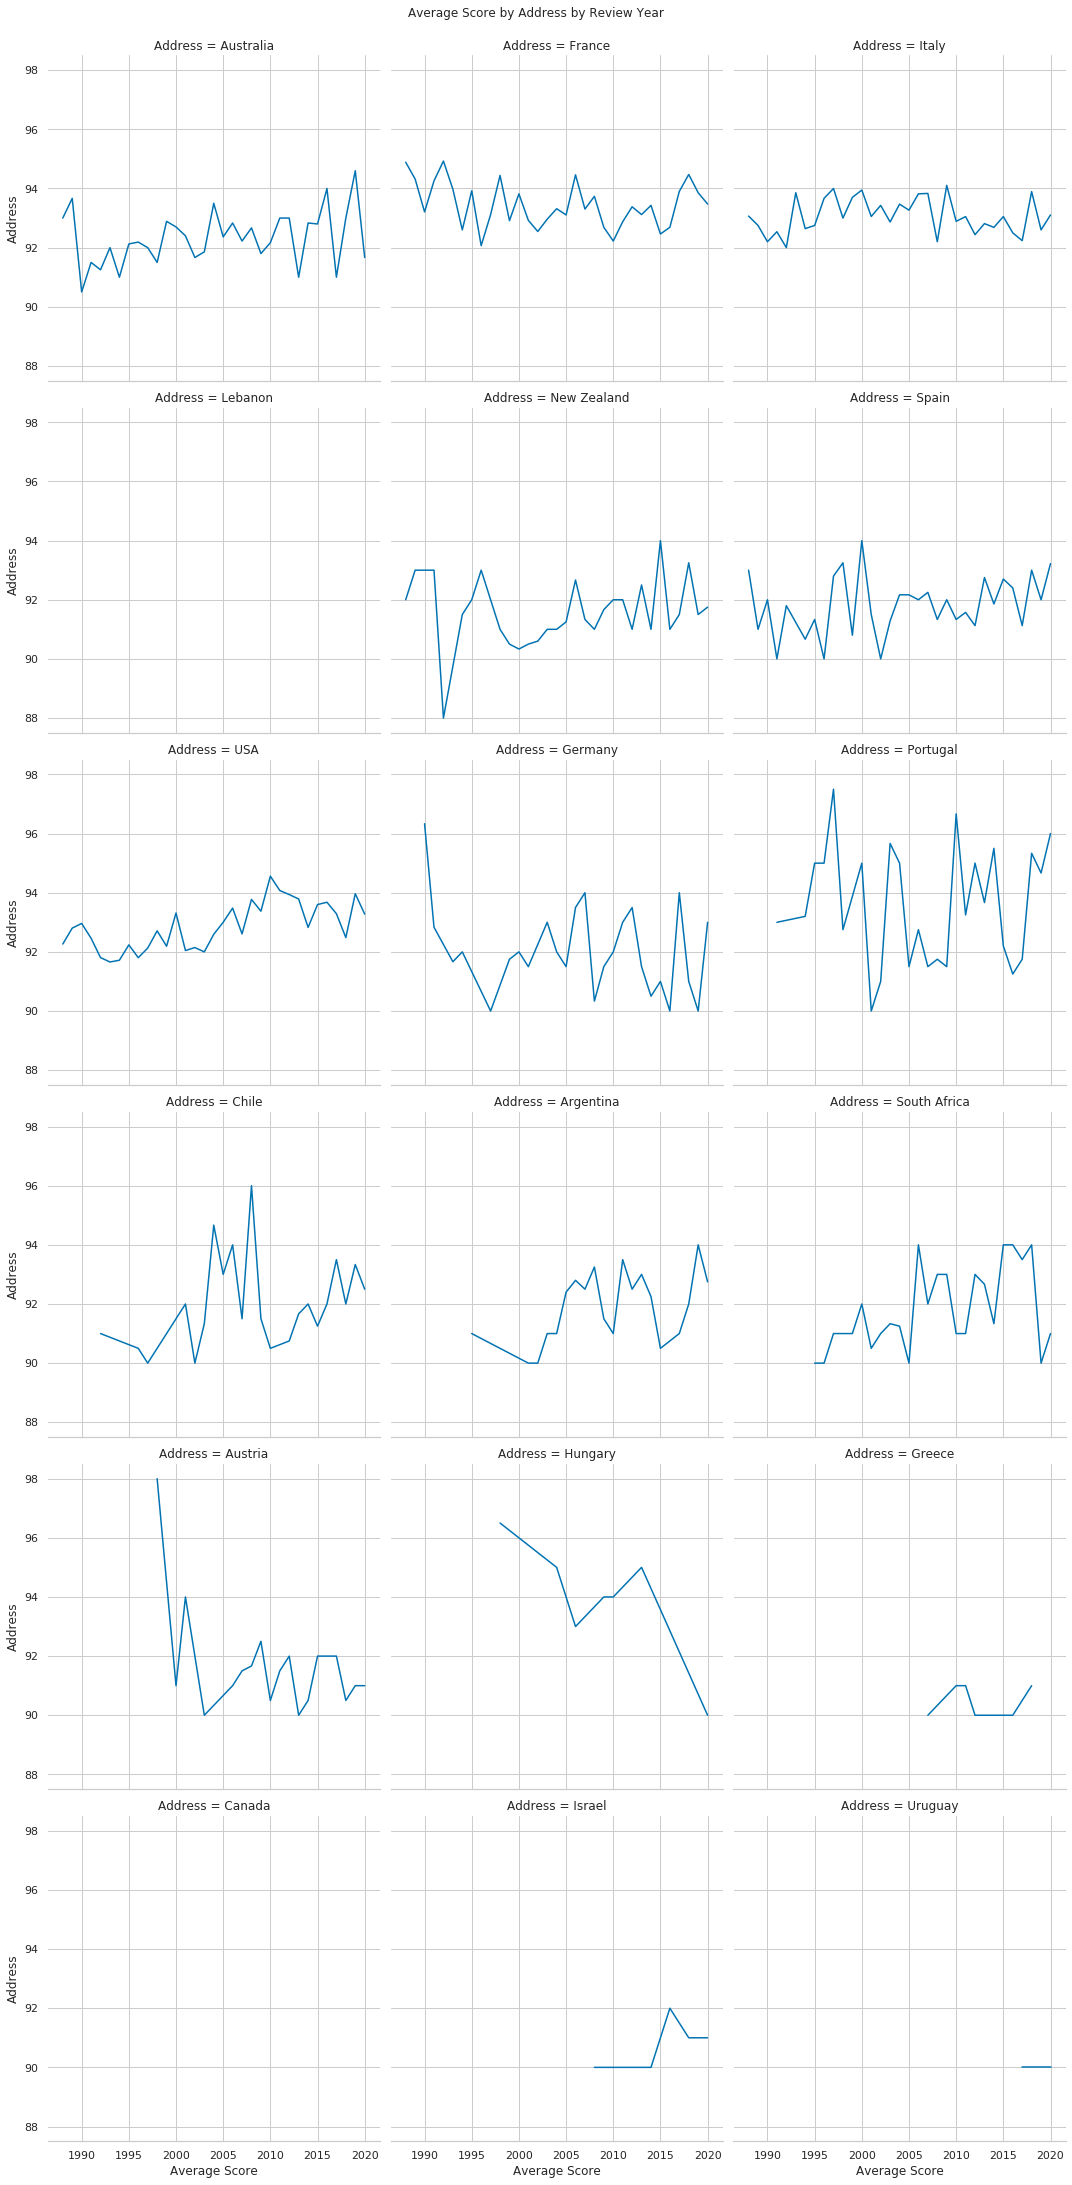

In [379]:
summary_by_year_lineplot('Score', 'Address')